<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#因子预处理例子:-市值因子" data-toc-modified-id="因子预处理例子:-市值因子-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>因子预处理例子: 市值因子</a></span><ul class="toc-item"><li><span><a href="#winsorized-data" data-toc-modified-id="winsorized-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>winsorized data</a></span></li><li><span><a href="#标准化" data-toc-modified-id="标准化-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>标准化</a></span></li><li><span><a href="#neut" data-toc-modified-id="neut-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>neut</a></span></li></ul></li><li><span><a href="#使用Alphalens研究因子" data-toc-modified-id="使用Alphalens研究因子-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>使用Alphalens研究因子</a></span><ul class="toc-item"><li><span><a href="#alphalens-的数据整合" data-toc-modified-id="alphalens-的数据整合-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>alphalens 的数据整合</a></span></li><li><span><a href="#生成报告" data-toc-modified-id="生成报告-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>生成报告</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import time
%matplotlib inline

In [6]:
size_data = pd.read_hdf("demo_tpd.h5")

In [7]:
size_data.head()

,data_date,secucode,daily_return,mv,free_mv,turnover,ind_code
0,2013-01-22,000001.SZ,0.074741,1.009300e+07,6.117555e+06,0.015266,480000
1,2013-01-22,000002.SZ,0.099802,1.077451e+07,1.075402e+07,0.002420,430000
2,2013-01-22,000004.SZ,0.001161,7.238790e+04,7.230065e+04,0.015264,370000
3,2013-01-22,000005.SZ,0.013201,2.807004e+05,2.805191e+05,0.031962,430000
4,2013-01-22,000006.SZ,0.038610,6.917117e+05,6.807696e+05,0.046717,210000


In [8]:
size_data_one_day = size_data[size_data['data_date']=='2013-01-22']

In [9]:
size_data_one_day.head()

,data_date,secucode,daily_return,mv,free_mv,turnover,ind_code
0,2013-01-22,000001.SZ,0.074741,1.009300e+07,6.117555e+06,0.015266,480000
1,2013-01-22,000002.SZ,0.099802,1.077451e+07,1.075402e+07,0.002420,430000
2,2013-01-22,000004.SZ,0.001161,7.238790e+04,7.230065e+04,0.015264,370000
3,2013-01-22,000005.SZ,0.013201,2.807004e+05,2.805191e+05,0.031962,430000
4,2013-01-22,000006.SZ,0.038610,6.917117e+05,6.807696e+05,0.046717,210000


"mv" 是流通市值, plot 2013-01-22的流通市值可以看出来流通市值的分布并不是正态分布

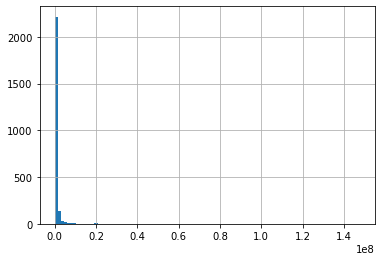

In [6]:
_ = size_data_one_day['mv'].hist(bins=100)

这里对原始的流通市值信号取对数, 可以达到中性化的效果

In [7]:
size_data["signal_raw"] = -np.log(size_data["mv"])

In [8]:
size_data_one_data = size_data[size_data["data_date"]=="2013-01-22"]

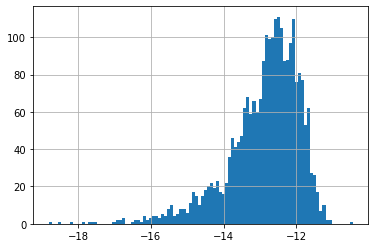

In [9]:
_ = size_data_one_data["signal_raw"].hist(bins=100)

把数据存储到本地

In [10]:
size_data[["data_date", "secucode", "signal_raw"]].to_hdf("size_signal_raw.h5", key="data")

# 因子预处理例子: 市值因子

In [11]:
signal_file_name = "size_signal_raw.h5"
signal = pd.read_hdf(signal_file_name, key="data")

In [12]:
signal.head()

,data_date,secucode,signal_raw
0,2013-01-22,000001.SZ,-16.127353
1,2013-01-22,000002.SZ,-16.192693
2,2013-01-22,000004.SZ,-11.189794
3,2013-01-22,000005.SZ,-12.545043
4,2013-01-22,000006.SZ,-13.446925


## winsorized data

In [13]:
signal_one_day = signal[signal["data_date"]=="2013-01-28"]

In [14]:
signal_one_day.head()

,data_date,secucode,signal_raw
9824,2013-01-28,000001.SZ,-16.099037
9825,2013-01-28,000002.SZ,-16.242638
9826,2013-01-28,000004.SZ,-11.142280
9827,2013-01-28,000005.SZ,-12.564399
9828,2013-01-28,000006.SZ,-13.433828


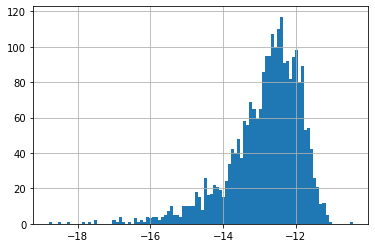

In [15]:
_ = signal_one_day.signal_raw.hist(bins=100)

In [16]:
ceiling = signal_one_day["signal_raw"].quantile(0.975)
floor = signal_one_day["signal_raw"].quantile(0.025)

把超过两端分位的值,取值为分位值

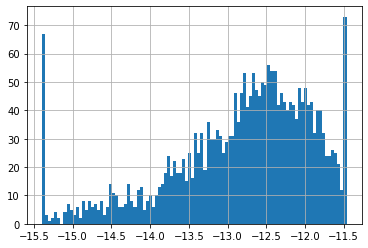

In [17]:
_ = signal_one_day["signal_raw"].apply(lambda x: ceiling if x > ceiling else (floor if x < floor else x)).hist(bins=100)

把上述过程写成函数

In [18]:
def winsor(signal_one_day):
    ceiling = signal_one_day["signal_raw"].quantile(0.975)
    floor = signal_one_day["signal_raw"].quantile(0.025)
    signal_one_day.loc[signal_one_day["signal_raw"] > ceiling, "signal_raw"] = ceiling
    signal_one_day.loc[signal_one_day["signal_raw"] < floor, "signal_raw"] = floor
    return signal_one_day["signal_raw"]

In [19]:
signal.sort_values(["data_date", "secucode"], inplace=True)
signal["signal_win"] = signal.groupby("data_date").apply(winsor).values

In [20]:
signal.describe()

,signal_raw,signal_win
count,3.425844e+06,3.425844e+06
mean,-1.348872e+01,-1.347327e+01
std,9.620232e-01,8.980427e-01
min,-1.928448e+01,-1.632216e+01
25%,-1.400178e+01,-1.400178e+01
50%,-1.336576e+01,-1.336576e+01
75%,-1.284497e+01,-1.284538e+01
max,-1.005019e+01,-1.143697e+01


可以看到winsor处理后过的信号最大最小值都发生了变化

## 标准化

In [21]:
def std(ser):
    return (ser-ser.mean()) / ser.std()

In [22]:
signal.head()

,data_date,secucode,signal_raw,signal_win
0,2013-01-22,000001.SZ,-16.127353,-15.422049
1,2013-01-22,000002.SZ,-16.192693,-15.422049
2,2013-01-22,000004.SZ,-11.189794,-11.523247
3,2013-01-22,000005.SZ,-12.545043,-12.545043
4,2013-01-22,000006.SZ,-13.446925,-13.446925


In [23]:
signal.sort_values(["data_date", "secucode"], inplace=True)

In [24]:
signal["signal_std"] = signal.groupby("data_date")["signal_win"].apply(std)

In [25]:
signal_one_day = signal[signal["data_date"] == "2013-01-22"]

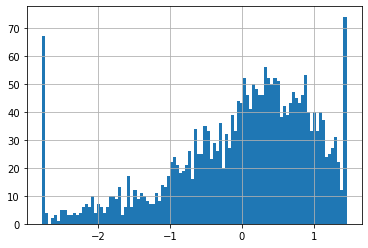

In [26]:
_ = signal_one_day["signal_std"].hist(bins=100)

In [27]:
signal_one_day.describe()

,signal_raw,signal_win,signal_std
count,2456.000000,2456.000000,2.456000e+03
mean,-12.879188,-12.863321,2.545919e-16
std,0.997251,0.921929,1.000000e+00
min,-18.809413,-15.422049,-2.775407e+00
25%,-13.353652,-13.353652,-5.318536e-01
50%,-12.687137,-12.687137,1.911042e-01
75%,-12.174631,-12.174631,7.470106e-01
max,-10.446230,-11.523247,1.453555e+00


可以看到signal_std的均值已经是0了

In [28]:
signal[["data_date", "secucode", "signal_std"]].to_hdf("size_signal_final.h5", key="data")

## neut

In [29]:
import statsmodels.api as sm
def neut(y, x):
    X = sm.add_constant(x)
    results = sm.OLS(y, X).fit()
    return results.resid

In [30]:
signal_one_day = signal[signal["data_date"] == "2013-01-28"]

In [31]:
signal_one_day.head()

,data_date,secucode,signal_raw,signal_win,signal_std
9824,2013-01-28,000001.SZ,-16.099037,-15.393349,-2.767558
9825,2013-01-28,000002.SZ,-16.242638,-15.393349,-2.767558
9826,2013-01-28,000004.SZ,-11.142280,-11.463326,1.464152
9827,2013-01-28,000005.SZ,-12.564399,-12.564399,0.278556
9828,2013-01-28,000006.SZ,-13.433828,-13.433828,-0.657615


In [32]:
demo_tpd = pd.read_hdf("demo_tpd.h5", key="data")
demo_tpd.head()

,data_date,secucode,daily_return,mv,free_mv,turnover,ind_code
0,2013-01-22,000001.SZ,0.074741,1.009300e+07,6.117555e+06,0.015266,480000
1,2013-01-22,000002.SZ,0.099802,1.077451e+07,1.075402e+07,0.002420,430000
2,2013-01-22,000004.SZ,0.001161,7.238790e+04,7.230065e+04,0.015264,370000
3,2013-01-22,000005.SZ,0.013201,2.807004e+05,2.805191e+05,0.031962,430000
4,2013-01-22,000006.SZ,0.038610,6.917117e+05,6.807696e+05,0.046717,210000


下面做行业中性

In [33]:
signal = signal[["data_date", "secucode", "signal_std"]]

In [37]:
signal  = signal.merge(demo_tpd[["data_date", "secucode", "ind_code"]], on=["data_date", "secucode"])

In [39]:
signal.isnull().sum()

data_date     0
secucode      0
signal_std    0
ind_code      0
dtype: int64

In [41]:
signal.head()

,data_date,secucode,signal_std,ind_code
0,2013-01-22,000001.SZ,-2.775407,480000
1,2013-01-22,000002.SZ,-2.775407,430000
2,2013-01-22,000004.SZ,1.453555,370000
3,2013-01-22,000005.SZ,0.345230,430000
4,2013-01-22,000006.SZ,-0.633025,210000


In [43]:
ind_code_list = signal.ind_code.unique()

In [44]:
ind_code_list

array(['480000', '430000', '370000', '210000', '460000', '240000',
       '510000', '620000', '610000', '330000', '280000', '340000',
       '270000', '710000', '420000', '360000', '410000', '730000',
       '110000', '640000', '450000', '220000', '720000', '350000',
       '630000', '490000', '230000', '650000'], dtype=object)

In [46]:
for ind_code_col in ind_code_list:
    signal[ind_code_col] = (signal["ind_code"] == ind_code_col) * 1

In [47]:
signal.head()

,data_date,secucode,signal_std,ind_code,480000,430000,370000,210000,460000,240000,...,110000,640000,450000,220000,720000,350000,630000,490000,230000,650000
0,2013-01-22,000001.SZ,-2.775407,480000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-22,000002.SZ,-2.775407,430000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-22,000004.SZ,1.453555,370000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-22,000005.SZ,0.345230,430000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-22,000006.SZ,-0.633025,210000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
del signal["ind_code"]

In [49]:
signal_one_day = signal[signal["data_date"] == "2013-01-28"] 

In [50]:
signal_one_day.head()

,data_date,secucode,signal_std,480000,430000,370000,210000,460000,240000,510000,...,110000,640000,450000,220000,720000,350000,630000,490000,230000,650000
9824,2013-01-28,000001.SZ,-2.767558,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9825,2013-01-28,000002.SZ,-2.767558,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9826,2013-01-28,000004.SZ,1.464152,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9827,2013-01-28,000005.SZ,0.278556,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9828,2013-01-28,000006.SZ,-0.657615,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
signal_one_day[ind_code_list].head()

,480000,430000,370000,210000,460000,240000,510000,620000,610000,330000,...,110000,640000,450000,220000,720000,350000,630000,490000,230000,650000
9824,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9825,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9826,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9827,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9828,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
signal_one_day["signal_neuted"] = neut(signal_one_day["signal_std"], signal_one_day[ind_code_list])

c:\Users\user\Anaconda3\envs\backtrader_py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
one_ind = signal_one_day[signal_one_day["480000"] == 1]

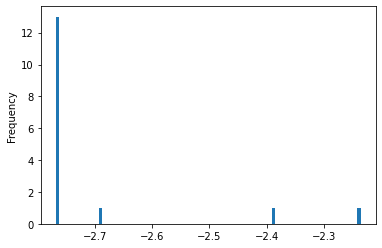

In [61]:
_ = one_ind["signal_std"].plot.hist(bins=100)

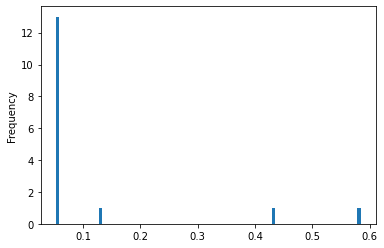

In [63]:
_ = one_ind["signal_neuted"].plot.hist(bins=100)

In [78]:
signal.sort_values(["data_date", "secucode"], inplace=True)
signal["signal_neuted"] = signal.groupby("data_date").apply(lambda x: neut(x["signal_std"], x[ind_code_list])).values

In [79]:
signal.head()

,data_date,secucode,signal_std,480000,430000,370000,210000,460000,240000,510000,...,640000,450000,220000,720000,350000,630000,490000,230000,650000,signal_neuted
0,2013-01-22,000001.SZ,-2.775407,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.032210
1,2013-01-22,000002.SZ,-2.775407,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.629900
2,2013-01-22,000004.SZ,1.453555,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.563906
3,2013-01-22,000005.SZ,0.345230,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.490738
4,2013-01-22,000006.SZ,-0.633025,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.368928


In [82]:
signal[["data_date", "secucode", "signal_neuted"]].to_hdf("size_signal.h5", key="data")

# 使用Alphalens研究因子

In [34]:
import alphalens

In [3]:
info_panel = pd.read_hdf("demo_tpd.h5")

In [4]:
factor_df = pd.read_hdf("size_signal_final.h5")

In [5]:
factor_df.head()

,data_date,secucode,signal_std
0,2013-01-22,000001.SZ,-2.775407
1,2013-01-22,000002.SZ,-2.775407
2,2013-01-22,000004.SZ,1.453555
3,2013-01-22,000005.SZ,0.345230
4,2013-01-22,000006.SZ,-0.633025


## alphalens 的数据整合

alphalens希望factor是一个multiple index frame

In [6]:
factor_df = factor_df.set_index(["data_date", "secucode"])

In [7]:
factor_df.head()

signal_std
data_date  secucode             
2013-01-22 000001.SZ   -2.775407
           000002.SZ   -2.775407
           000004.SZ    1.453555
           000005.SZ    0.345230
           000006.SZ   -0.633025

利用股票return来拟合一个虚拟价格, 用于规避分红, 除权除息价格的影响

In [8]:
info_panel.head()

,data_date,secucode,daily_return,mv,free_mv,turnover,ind_code
0,2013-01-22,000001.SZ,0.074741,1.009300e+07,6.117555e+06,0.015266,480000
1,2013-01-22,000002.SZ,0.099802,1.077451e+07,1.075402e+07,0.002420,430000
2,2013-01-22,000004.SZ,0.001161,7.238790e+04,7.230065e+04,0.015264,370000
3,2013-01-22,000005.SZ,0.013201,2.807004e+05,2.805191e+05,0.031962,430000
4,2013-01-22,000006.SZ,0.038610,6.917117e+05,6.807696e+05,0.046717,210000


In [9]:
info_panel.sort_values(["secucode", "data_date"], inplace=True)

In [10]:
info_panel

,data_date,secucode,daily_return,mv,free_mv,turnover,ind_code
0,2013-01-22,000001.SZ,0.074741,1.009300e+07,6.117555e+06,0.015266,480000
2456,2013-01-23,000001.SZ,0.039594,1.049262e+07,6.359773e+06,0.020861,480000
4912,2013-01-24,000001.SZ,-0.020996,1.027232e+07,6.226243e+06,0.012408,480000
7368,2013-01-25,000001.SZ,-0.029925,9.964917e+06,6.039921e+06,0.016732,480000
9824,2013-01-28,000001.SZ,-0.015424,9.811216e+06,5.946761e+06,0.011990,480000
...,...,...,...,...,...,...,...
3411919,2018-01-29,603999.SH,-0.002407,4.775040e+05,1.910016e+05,0.010884,720000
3415399,2018-01-30,603999.SH,-0.032569,4.619520e+05,1.847808e+05,0.009778,720000
3418879,2018-01-31,603999.SH,-0.007481,4.584960e+05,1.833984e+05,0.003701,720000
3422360,2018-02-01,603999.SH,-0.041457,4.394880e+05,1.757952e+05,0.005529,720000


In [12]:
info_panel.loc[:, "return_plus_one"] = info_panel["daily_return"] + 1

In [18]:
info_panel.loc[:, "close"] = info_panel.groupby("secucode")["return_plus_one"].expanding().apply(np.prod).values

In [19]:
price_df = info_panel[["data_date", "secucode", "close"]].pivot(index="data_date", columns="secucode", values="close")

In [20]:
price_df.head()

secucode,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,603987.SH,603988.SH,603989.SH,603990.SH,603991.SH,603993.SH,603996.SH,603997.SH,603998.SH,603999.SH
data_date,,,,,,,,,,,,,,,,,,,,,
2013-01-22,1.074741,1.099802,1.001161,1.013201,1.038610,0.979092,1.013986,0.995680,1.0,0.998672,...,NaN,NaN,NaN,NaN,NaN,1.016848,NaN,NaN,NaN,NaN
2013-01-23,1.117294,1.162055,0.975610,0.990099,1.017375,0.958184,1.048077,0.966523,1.0,0.976096,...,NaN,NaN,NaN,NaN,NaN,0.989098,NaN,NaN,NaN,NaN
2013-01-24,1.093835,1.155138,0.996516,1.089109,1.069498,0.958781,1.047203,0.984881,1.0,1.061089,...,NaN,NaN,NaN,NaN,NaN,0.969277,NaN,NaN,NaN,NaN
2013-01-25,1.061102,1.180830,0.961672,1.062706,1.023166,0.910394,1.013986,0.990281,1.0,1.003984,...,NaN,NaN,NaN,NaN,NaN,0.904856,NaN,NaN,NaN,NaN
2013-01-28,1.044735,1.156126,0.954704,1.033003,1.025097,0.922939,1.032343,0.970842,1.0,0.973440,...,NaN,NaN,NaN,NaN,NaN,0.919722,NaN,NaN,NaN,NaN


In [21]:
group_df = info_panel[["data_date", "secucode", "ind_code"]].sort_values(["data_date", "secucode"]).set_index(["data_date", "secucode"])

In [23]:
group_df.head()

ind_code
data_date  secucode          
2013-01-22 000001.SZ   480000
           000002.SZ   430000
           000004.SZ   370000
           000005.SZ   430000
           000006.SZ   210000

In [25]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_df, price_df, quantiles=10)

Dropped 1.0% entries from factor data: 1.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [26]:
factor_data

1D        5D           10D    factor  \
date       asset                                                   
2013-01-22 000001.SZ  0.039594  0.069543  1.172589e-01 -2.775407   
           000002.SZ  0.056604  0.083558  6.918239e-02 -2.775407   
           000004.SZ -0.025522  0.048724  5.684455e-02  1.453555   
           000005.SZ -0.022801  0.032573  9.771987e-03  0.345230   
           000006.SZ -0.020446  0.018587 -4.440892e-16 -0.633025   
...                        ...       ...           ...       ...   
2018-01-19 603993.SH  0.002475  0.011139 -7.797030e-02 -2.718379   
           603996.SH  0.005656  0.004525 -1.131222e-01  0.404195   
           603997.SH  0.014912 -0.001754 -4.561404e-02  0.065257   
           603998.SH -0.028205 -0.029060 -1.042735e-01  0.461504   
           603999.SH  0.005202  0.080624 -7.022107e-02  0.606570   

                      factor_quantile  
date       asset                       
2013-01-22 000001.SZ                1  
           000002.SZ                1  
           000004.SZ               10  
           000005.SZ                6  
           000006.SZ                3  
...                               ...  
2018-01-19 603993.SH                1  
           603996.SH                6  
           603997.SH                5  
           603998.SH                7  
           603999.SH                7  

[3391041 rows x 5 columns]

## 生成报告

Returns Analysis


,1D,5D,10D
Ann. alpha,0.192,0.212,0.203
beta,0.094,0.130,0.146
Mean Period Wise Return Top Quantile (bps),36.104,40.871,40.391
Mean Period Wise Return Bottom Quantile (bps),4.888,4.856,4.719
Mean Period Wise Spread (bps),31.216,35.219,34.502


<Figure size 432x288 with 0 Axes>

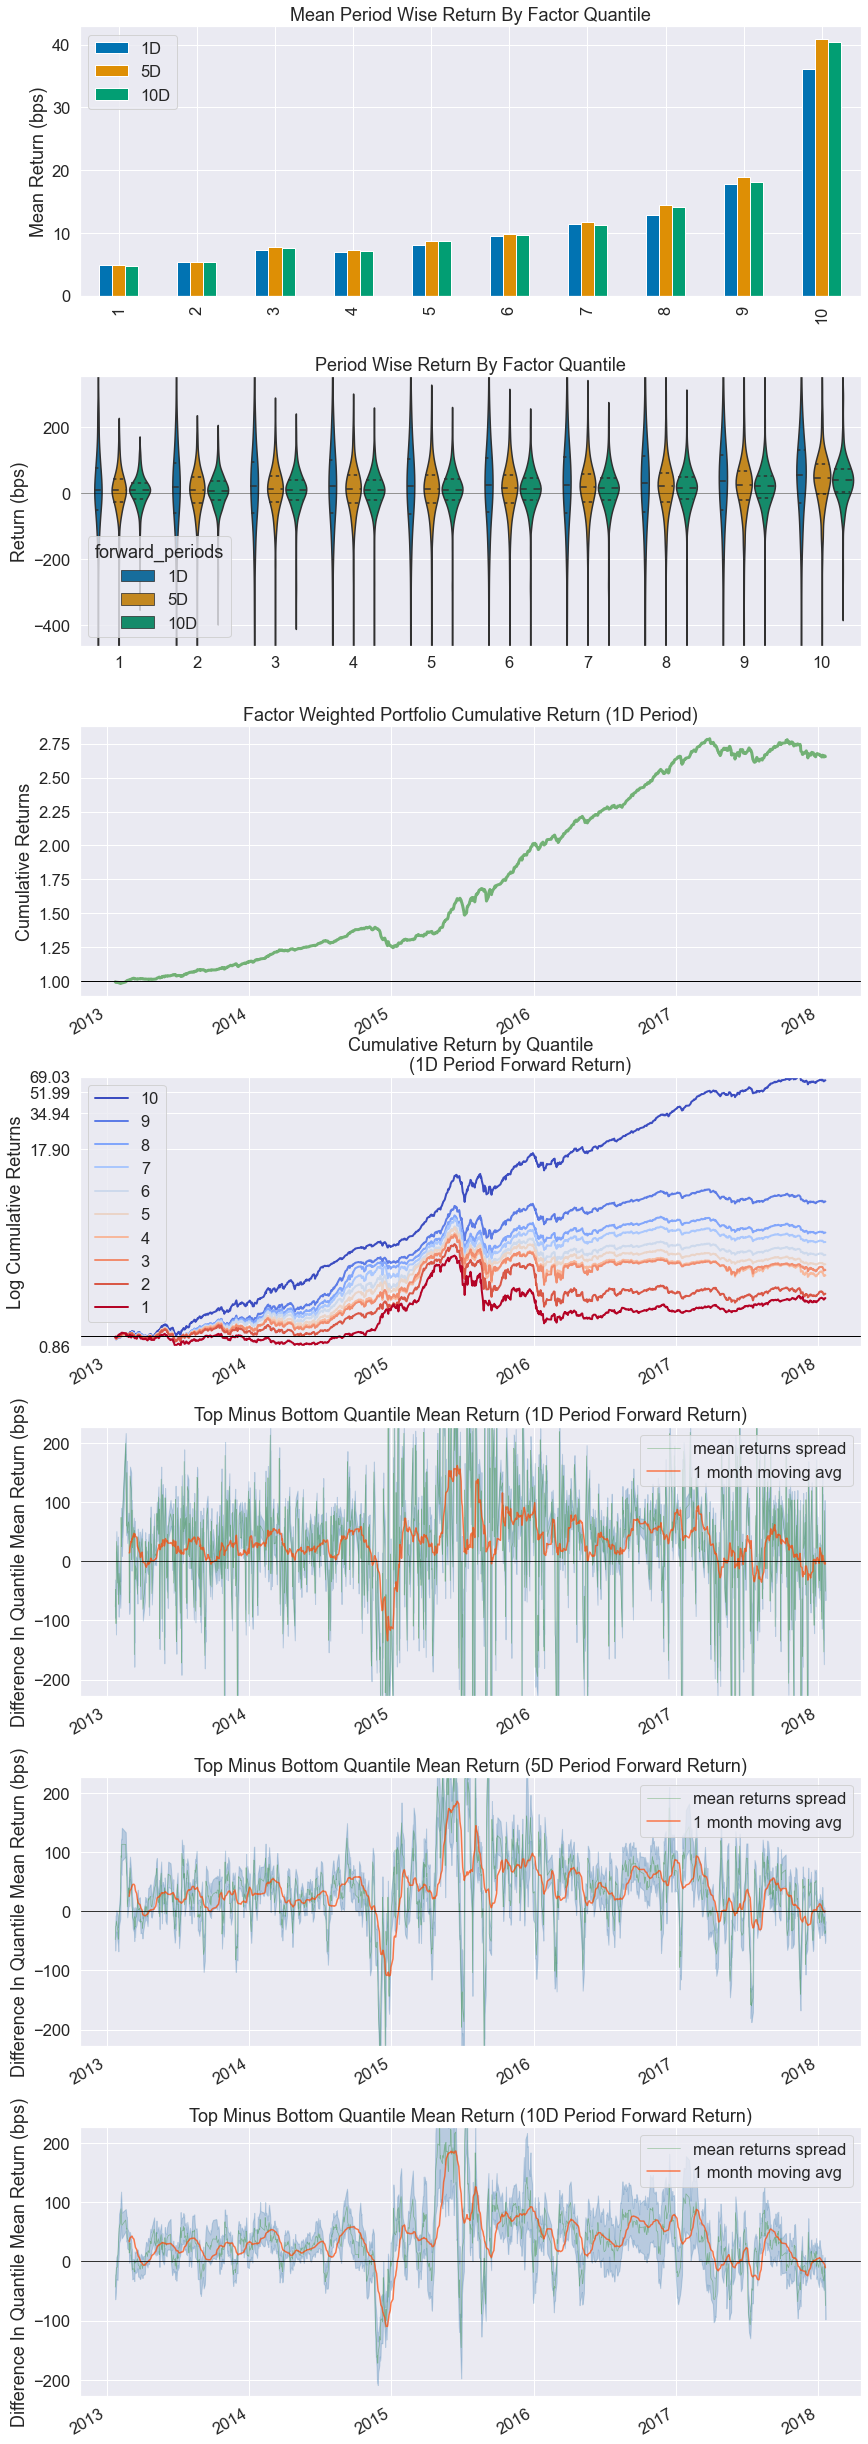

In [27]:
alphalens.tears.create_returns_tear_sheet(factor_data, long_short=False)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-2.844131,-1.381861,-2.116157,0.458144,339689,10.017248
2,-1.490843,-0.729289,-1.071350,0.191097,338971,9.996075
3,-0.840249,-0.341755,-0.570234,0.115975,338927,9.994777
4,-0.444395,-0.025446,-0.214292,0.092859,338972,9.996104
5,-0.133877,0.227116,0.065989,0.075495,339298,10.005718
6,0.153077,0.457629,0.305451,0.067071,338840,9.992212
7,0.387595,0.671437,0.531042,0.066168,338889,9.993657
8,0.598101,0.899084,0.755189,0.066948,339013,9.997314
9,0.837784,1.187077,0.998509,0.077843,338884,9.993509


Returns Analysis


,1D,5D,10D
Ann. alpha,0.192,0.212,0.203
beta,0.094,0.130,0.146
Mean Period Wise Return Top Quantile (bps),36.104,40.871,40.391
Mean Period Wise Return Bottom Quantile (bps),4.888,4.856,4.719
Mean Period Wise Spread (bps),31.216,35.219,34.502


<Figure size 432x288 with 0 Axes>

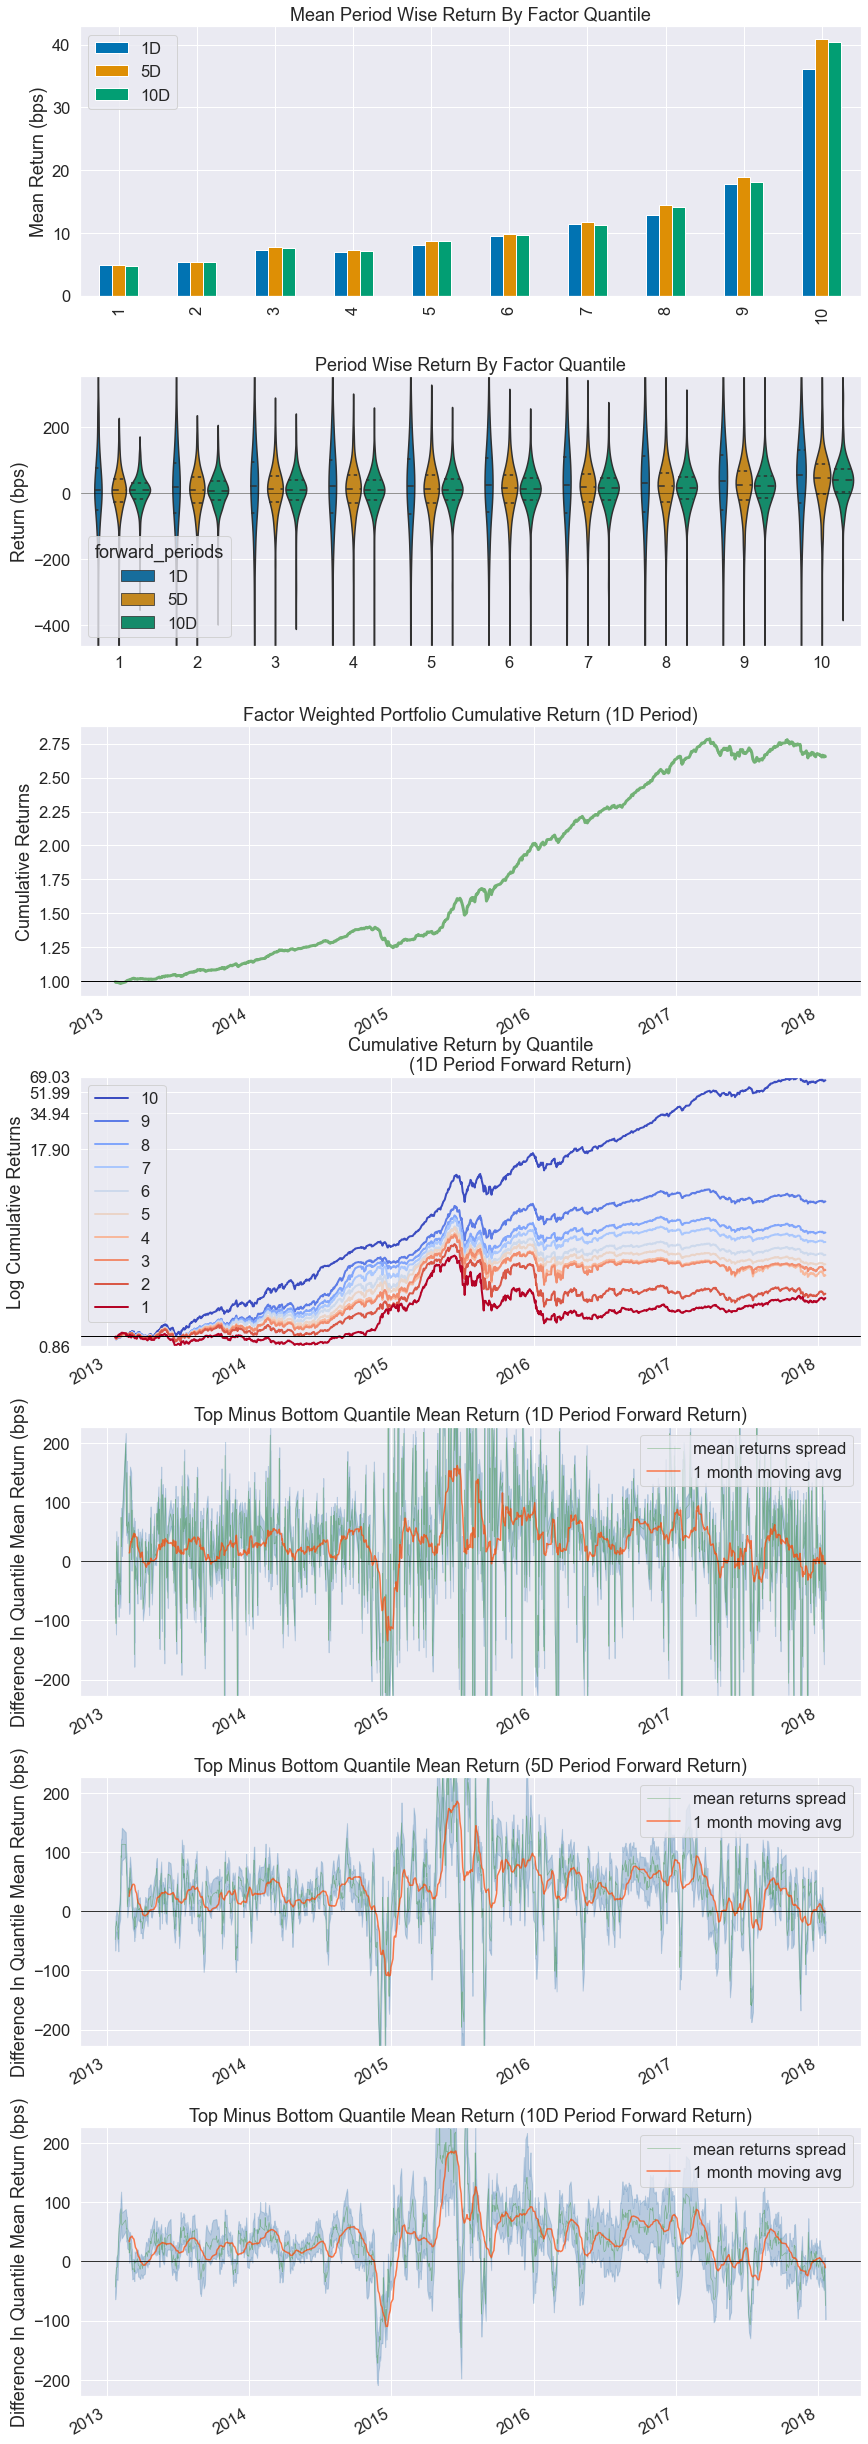

Information Analysis


,1D,5D,10D
IC Mean,0.032,0.053,0.066
IC Std.,0.120,0.143,0.156
Risk-Adjusted IC,0.270,0.369,0.425
t-stat(IC),9.418,12.880,14.813
p-value(IC),0.000,0.000,0.000
IC Skew,-0.515,-0.647,-0.651
IC Kurtosis,0.586,0.220,-0.109


c:\Users\user\Anaconda3\envs\alphalens\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\user\Anaconda3\envs\alphalens\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\user\Anaconda3\envs\alphalens\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

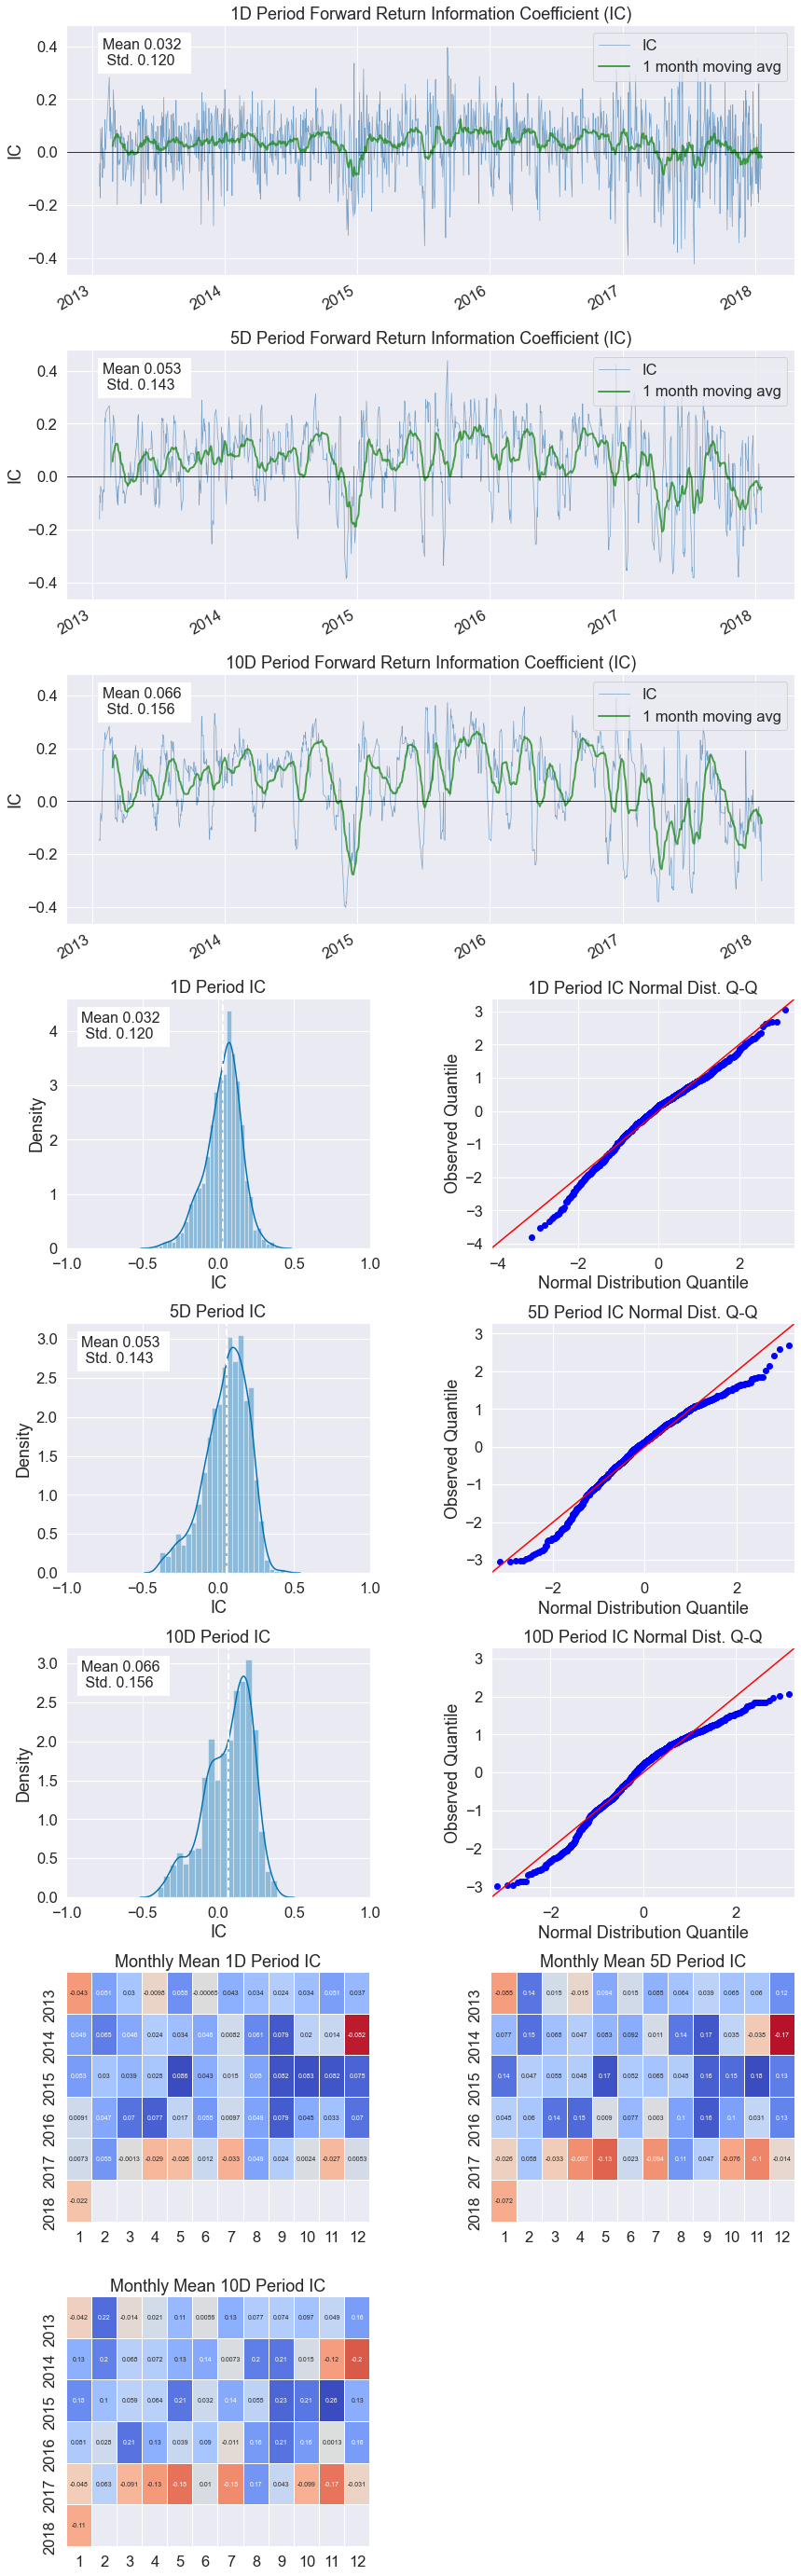

c:\Users\user\Anaconda3\envs\alphalens\lib\site-packages\alphalens\utils.py:911: UserWarning: Skipping return periods that aren't exact multiples of days.
  "Skipping return periods that aren't exact multiples"


AttributeError: 'Index' object has no attribute 'get_values'

In [35]:
alphalens.tears.create_full_tear_sheet(factor_data, long_short=False)